In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

First we simulate JFK and Standard Rate rides with the same linear regression as in the data, but with no error. This should be extremely easy to fit with the standard EM algorithm.

In [7]:
distances = np.random.uniform(0, 60, size = 10000).reshape(10000, -1)
trip_type = np.random.randint(0, 1+1, size = 10000).reshape(10000, -1)
beta_0 = 52 * trip_type
beta_1 = 2.29 * (1 - trip_type)
cost = beta_0 + distances * beta_1
cost = cost.reshape(-1)

Compare the scatter plot below to the scatter plot from our project proposal.

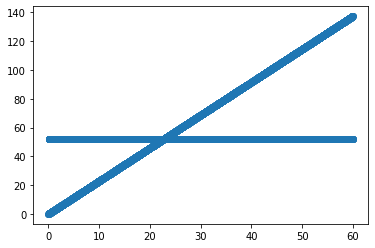

In [8]:
plt.scatter(distances, cost)

In [62]:
def initialize_classic(n_features, mean = 0.0, sd = 1.0):
    betas = {}
    for i in range(2):
        betas[i] = np.random.normal(mean, sd, n_features)
    return(betas)

def initialize_optimal(X, y, delta=0.3):
    M = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[1]):
        M += y[i]**2 * np.outer(X[:,i], X[:,i])
    M /= X.shape[1]
    
    eigenvalues, eigenvectors = np.linalg.eig(M)
    sorted_eigs = sorted(zip(eigenvalues, eigenvectors), key=lambda x: x[0], reverse=True)
    v1 = sorted_eigs[0][1]
    v2 = sorted_eigs[1][1]
    
    t_vals = np.arange(int(np.ceil(2 * np.pi / delta)) + 1).reshape(1, -1, 1)
    G = v1 * np.cos(delta * t_vals) + v2 * np.sin(delta * t_vals)
    G = G.reshape(-1, 2)
    min_loss = np.inf
    for u1 in G:
        for u2 in G:
            l1 = y - u1.dot(X)
            l2 = y - u2.dot(X)
            optim_mask = np.abs(l1) < np.abs(l2)
            l1 = l1[optim_mask]
            l2 = l2[~optim_mask]
            loss = np.sum(l1**2) + np.sum(l2**2)
            if loss < min_loss:
                min_loss = loss
                betas = {0:u1, 1:u2}
    return(betas)     
            
def run_EM_iteration(X, y, betas):
    pred0 = X.transpose().dot(betas[0])
    pred1 = X.transpose().dot(betas[1])
    err0 = np.abs(pred0 - y)
    err1 = np.abs(pred1 - y)
    lower_error = (err0 < err1)
    j0_ind = np.where(lower_error)
    j1_ind = np.where(~lower_error)
    X_0 = X[:, j0_ind].reshape(2,-1)
    X_1 = X[:,j1_ind].reshape(2,-1)
    
    ##Solve least squares 
    try:
        beta_0 = np.linalg.inv(X_0.dot(X_0.transpose())).dot(X_0).dot(y[j0_ind])
    except:
        beta_0 = betas[0]
    
    try:
        beta_1 = np.linalg.inv(X_1.dot(X_1.transpose())).dot(X_1).dot(y[j1_ind])
    except:
        beta_1 = betas[1]
    
    betas = {0: beta_0,
             1: beta_1}
    
    iter_err_0 = np.sum((beta_0.dot(X_0) - y[j0_ind])**2)
    iter_err_1 = np.sum((beta_1.dot(X_1) - y[j1_ind])**2)
    iter_err = np.log(np.sqrt((iter_err_0 + iter_err_1) / X.shape[1])) # log RMSE
    
    return(betas, iter_err)

def fit_mixed_regression(x, y, n_iter = 10, algo_type = 'classic'):
    n_samples = x.size
    ones = np.ones(x.size)
    X = np.array([ones, x.reshape(-1)])
    
    #initialize parameters
    if algo_type == 'classic':
        betas = initialize_classic(X.shape[0])
    else:
        betas = initialize_optimal(X, y)

    iter_errs = []
    for j in range(n_iter):
        betas, iter_err = run_EM_iteration(X, y, betas)
        iter_errs.append(iter_err)
    return(betas, iter_errs)

In [10]:
np.random.seed(2)
betas, iter_errs_classic = fit_mixed_regression(distances, cost, algo_type = 'classic')
betas_opt, iter_errs_opt = fit_mixed_regression(distances, cost, algo_type = 'optimal')
print(betas)
print(betas_opt)

{0: array([3.16274784e-14, 2.29000000e+00]), 1: array([ 5.2000000e+01, -1.4972832e-16])}
{0: array([3.16274784e-14, 2.29000000e+00]), 1: array([ 5.2000000e+01, -1.4972832e-16])}


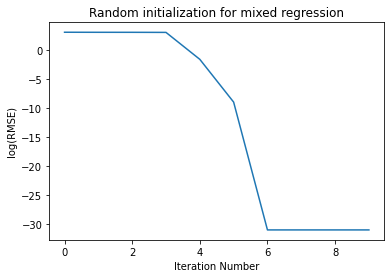

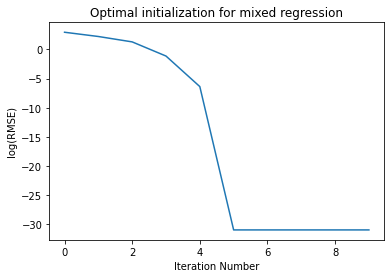

In [6]:
plt.plot(iter_errs_classic)
plt.xlabel('Iteration Number')
plt.ylabel('log(RMSE)')
plt.title('Random initialization for mixed regression')
plt.show()

plt.plot(iter_errs_opt)
plt.xlabel('Iteration Number')
plt.ylabel('log(RMSE)')
plt.title('Optimal initialization for mixed regression')
plt.show()

Below we write code to simulate data and run both fitting procedures. We also determine whether a fit converged to the true betas, or if it converged to some other local minimum (or otherwise failed to converge).

In [65]:
def create_trip_data(n_trips, error_size = 0):
    distances = np.random.uniform(0, 60, size = 10000).reshape(10000, -1)
    trip_type = np.random.randint(0, 1+1, size = 10000).reshape(10000, -1)
    beta_0 = 52 * trip_type
    beta_1 = 2.29 * (1 - trip_type)
    cost = beta_0 + distances * beta_1 + np.random.normal(0, error_size, 10000).reshape(-1,1)
    cost = cost.reshape(-1)
    return(distances, trip_type, cost)

def determine_global_convergence(learned_betas,
                                 true_betas = {0: np.array([0, 2.29]),
                                               1: np.array([52, 0])}):
    '''
    This function determines whether the fitting procedure converged to the global minimum
    or not. We want to see how often each procedure gets stuck at local minima. We will take
    the sum of the squared differences of the four parameters (intecept and slope for each latent
    class) from the true parameters.
    
    Note that the model is unidentifiable: what we call the first latent class might be found
    by the fitting procedure as the second class. Therefore, we try both matchings, and take
    the minimum of the two sum of squared differences.
    '''
    err1 = (true_betas[0][0] - learned_betas[0][0])**2 + (true_betas[0][1] - learned_betas[0][1])**2 + \
            (true_betas[1][0] - learned_betas[1][0])**2+ (true_betas[1][1] - learned_betas[1][1])**2
    err2 = (true_betas[0][0] - learned_betas[1][0])**2 + (true_betas[0][1] - learned_betas[1][1])**2 + \
            (true_betas[1][0] - learned_betas[0][0])**2+ (true_betas[1][1] - learned_betas[0][1])**2
    err = min(err1, err2)
    if err < 10**(-2):
        return 1.0
    else:
        return 0.0
    
def simulate_fits(n_trips, error_size, n_sims):

    all_iter_errs_classic = []
    all_iter_errs_opt = []
    all_iter_errs_classic_nolog = []
    all_iter_errs_opt_nolog = []
    convergence_record_classic = []
    convergence_record_opt = []
    
    for run_num in range(n_sims):
        distances, trip_type, cost = create_trip_data(n_trips, error_size)
        
        np.random.seed(run_num)
        betas_classic, iter_errs_classic = fit_mixed_regression(distances, cost, algo_type = 'classic')
        betas_opt, iter_errs_opt = fit_mixed_regression(distances, cost, algo_type = 'optimal')

        classic_converged = determine_global_convergence(betas_classic)
        optimal_converged = determine_global_convergence(betas_opt)
        
        all_iter_errs_classic.append(iter_errs_classic)
        all_iter_errs_opt.append(iter_errs_opt)
        all_iter_errs_classic_nolog.append(np.exp(iter_errs_classic))
        all_iter_errs_opt_nolog.append(np.exp(iter_errs_opt))
        convergence_record_classic.append(classic_converged)
        convergence_record_opt.append(optimal_converged)
        
    
    all_iter_errs_classic = np.array(all_iter_errs_classic)
    all_iter_errs_opt = np.array(all_iter_errs_opt)
    avg_errs_classic = np.mean(all_iter_errs_classic, axis = 0)
    avg_errs_opt = np.mean(all_iter_errs_opt, axis = 0)
    avg_errs_classic_nolog = np.mean(all_iter_errs_classic_nolog, axis = 0)
    avg_errs_opt_nolog = np.mean(all_iter_errs_opt_nolog, axis = 0)
    classic_convergence_rate = np.mean(np.array(convergence_record_classic))
    optimal_convergence_rate = np.mean(np.array(convergence_record_opt))
    
    print('Random initialization converged to true parameters with frequency ' + \
          str(classic_convergence_rate))
    print('Improved initialization converged to true parameters with frequency ' + \
          str(optimal_convergence_rate))
    
    plt.plot(avg_errs_classic, label = 'Classic')
    plt.plot(avg_errs_opt, label = 'Optimal')
    plt.title('Average of log')
    plt.legend()
    plt.show()
    
    plt.plot(np.log(avg_errs_classic_nolog), label = 'Classic')
    plt.plot(np.log(avg_errs_opt_nolog), label = 'Optimal')
    plt.title('Log of average')
    plt.legend()

The plot below shows the average error by iteration number. The classic error line is higher on the right because classic reaches bad local minima about 25% of the time. I'm not sure right now why the optimal converges a little more slowly. Probably a bug. This doesn't occur when error size is positive (see below).

Random initialization converged to true parameters with frequency 0.75
Improved initialization converged to true parameters with frequency 1.0


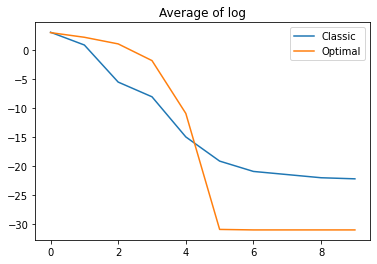

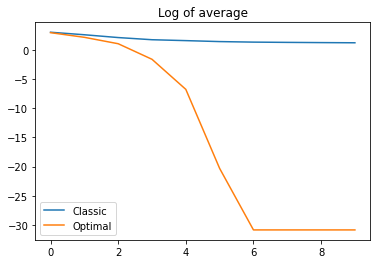

In [66]:
simulate_fits(n_trips = 10000, error_size = 0, n_sims = 200)z

Now we add some random noise to the costs.

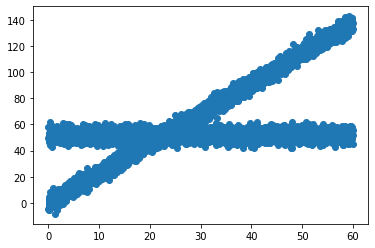

In [9]:
example_dist, _, example_cost = create_trip_data(10000, error_size = 3)
plt.scatter(example_dist, example_cost)

Note that both methods converge to the true parameters much less frequently. This is a little misleading. Because we've injected noise, the OLS solutions won't match the true betas exactly, even if we can guess the latent classes perfectly. It might be better to see if the fits converge to the correct OLS solutions.

Random initialization converged to true parameters with frequency 0.175
Improved initialization converged to true parameters with frequency 0.415


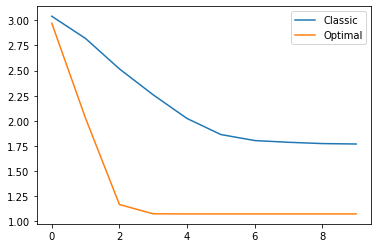

In [31]:
simulate_fits(n_trips = 10000, error_size = 3, n_sims = 200)